In [46]:
import sys
sys.path.append("..")

from ris_evaluation.evaluator import Evaluator

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
documents_df = pd.read_csv('../datasets/data/BBC_News/documents.csv')
documents_df = documents_df

documents = documents_df['document'].tolist()
labels = documents_df['class_name'].tolist()

In [18]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(documents)

lda = LatentDirichletAllocation(n_components=len(set(labels)), random_state=0)
lda.fit(X)

LatentDirichletAllocation(n_components=5, random_state=0)

In [45]:
results_df = pd.DataFrame()
results_df['document'] = documents
results_df['y_true'] = documents_df['class_name'].tolist()
results_df['y_pred'] = lda.transform(X).argmax(axis=1)
results_df['y_pred_highest_proba'] = lda.transform(X).max(axis=1)

results_df

,document,y_true,y_pred,y_pred_highest_proba
0,hit shelf combine medium player phone gaming g...,tech,2,0.910652
1,bid hope join host apply host tournament aim r...,sport,1,0.818584
2,lord wrong detainee straw straw attack decisio...,politics,3,0.758257
3,leak answer minister explain budget detail pri...,politics,0,0.571255
4,delight manager pay tribute goal striker beat ...,sport,1,0.977416
...,...,...,...,...
2220,rock clean steer clear bad language front awar...,entertainment,2,0.884496
2221,comedy meet sequel meet parent top week movie ...,entertainment,2,0.939132
2222,join rare group actress nominate oscar star fo...,entertainment,2,0.878861
2223,police chief back move chief back introduction...,politics,0,0.878932


In [35]:
def get_words_for_topics(topics):
    words_by_topics = {}
    for idx, topic in enumerate(topics):
        words = documents_df.iloc[idx]['document'].split()

        if topic not in words_by_topics:
            words_by_topics[topic] = {}

        for word in words:
            if word not in words_by_topics[topic]:
                words_by_topics[topic][word] = 0

            words_by_topics[topic][word] += 1

    return words_by_topics

In [33]:
def get_output(lda_model, vectorizer_model):
    topics = []
    for topic in lda_model.components_:
        topic_words = []
        for i in topic.argsort()[-10:]:
            topic_words.append(vectorizer_model.get_feature_names_out()[i])
        topics.append(topic_words)

    return {
        "topics": topics,
        "topic-document-matrix": None,
        "topic-word-matrix": None,
        "test-topic-document-matrix": None
    }

In [36]:
model_output = get_output(lda, vectorizer)
evaluator = Evaluator(model_output)

words_by_extracted_topics = get_words_for_topics(results_df['y_pred'].tolist())
words_by_class = get_words_for_topics(results_df['y_true'].tolist())

In [42]:
coherence = evaluator.compute_coherence()
diversity = evaluator.compute_diversity()
supervised_correlation = evaluator.compute_supervised_correlation(words_by_extracted_topics, words_by_class)

metrics_df = pd.DataFrame()

for coherence_type, coherence_value in coherence.items():
    metrics_df[f'Coherence ({coherence_type})'] = [coherence_value]
metrics_df['Diversity'] = [diversity]
metrics_df['Supervised correlation'] = [supervised_correlation]
metrics_df

,Coherence (c_v),Coherence (c_uci),Coherence (c_npmi),Coherence (u_mass),Diversity,Supervised correlation
0,0.465131,-0.154971,0.023076,-2.344902,0.94,0.739535


<Axes: xlabel='y_true', ylabel='y_pred_highest_proba'>

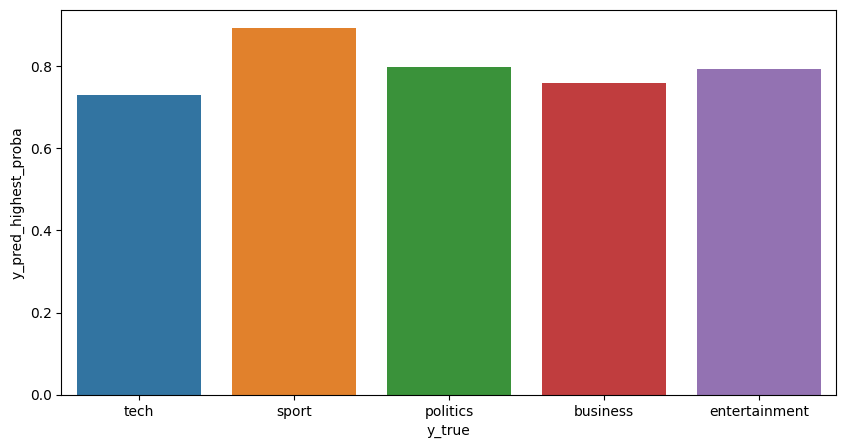

In [50]:
plt.figure(figsize=(10, 5))

sns.barplot(data=results_df, x='y_true', y='y_pred_highest_proba', errorbar=None)